In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
from springstone.data import get_data, get_missing_dates, create_train_test
from springstone.utils import bollinger_bands, moving_average, daily_return
from springstone.params import MODEL_TYPE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Normalization, Masking
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE, MAE
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2022-03-05 16:21:43.914397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-05 16:21:43.914452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Get the original data set for the AAPL ticker and keep the columns we need

In [4]:
hist_aapl = get_data('AAPL', end='2022-03-05').drop(columns=['High', 'Low'])

[*********************100%***********************]  1 of 1 completed


In [5]:
hist_aapl.shape

(2527, 3)

# Get the missing dates from the original data set and include them with forward filling

In [6]:
missing_dates_aapl = get_missing_dates(hist_aapl, True)

In [7]:
an_array = np.full((missing_dates_aapl.shape[0], hist_aapl.shape[1]), np.nan)
data = pd.concat([hist_aapl, pd.DataFrame(an_array, index=missing_dates_aapl, columns=hist_aapl.columns)])
data = data.sort_index()
data.rename_axis(index='Date', inplace=True)
hist_aapl = data.fillna(method='ffill')

In [8]:
hist_aapl

,Open,Close,Volume
Date,,,
2012-02-21,18.102858,18.387501,605595200.0
2012-02-22,18.324286,18.322857,483302400.0
2012-02-23,18.395714,18.442499,568027600.0
2012-02-24,18.559643,18.657499,415072000.0
2012-02-25,18.559643,18.657499,415072000.0
...,...,...,...
2022-02-28,163.059998,165.119995,94869100.0
2022-03-01,164.699997,163.199997,83474400.0
2022-03-02,164.389999,166.559998,79724800.0


# Add the the Bollinger Bands and the moving average features

In [9]:
hist_aapl = bollinger_bands(hist_aapl, 'Close', 20, 2)
hist_aapl = bollinger_bands(hist_aapl, 'Close', 20, -2)
hist_aapl = moving_average(hist_aapl, 'Close', 7)
hist_aapl = daily_return(hist_aapl, 'Close')

In [10]:
hist_aapl

,Open,Close,Volume,Close_bb20_2,Close_bb20_-2,Close_ma7,percentage_change
Date,,,,,,,
2012-02-21,18.102858,18.387501,605595200.0,NaN,NaN,NaN,NaN
2012-02-22,18.324286,18.322857,483302400.0,NaN,NaN,NaN,-0.003516
2012-02-23,18.395714,18.442499,568027600.0,NaN,NaN,NaN,0.006530
2012-02-24,18.559643,18.657499,415072000.0,NaN,NaN,NaN,0.011658
2012-02-25,18.559643,18.657499,415072000.0,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...
2022-02-28,163.059998,165.119995,94869100.0,175.264747,160.077257,163.828576,0.001638
2022-03-01,164.699997,163.199997,83474400.0,173.685535,160.348469,163.668575,-0.011628
2022-03-02,164.389999,166.559998,79724800.0,172.960391,160.517613,164.595716,0.020588


## Remove the trailing records with NaN values

In [11]:
hist_aapl.dropna(subset=['Close_bb20_2'], inplace=True)

In [12]:
hist_aapl

,Open,Close,Volume,Close_bb20_2,Close_bb20_-2,Close_ma7,percentage_change
Date,,,,,,,
2012-03-11,19.436071,19.470358,4.189192e+08,19.883297,18.212204,19.242909,0.000000
2012-03-12,19.606428,19.714287,4.072824e+08,19.939537,18.288642,19.339031,0.012528
2012-03-13,19.912144,20.289286,6.908552e+08,20.106623,18.318199,19.532093,0.029167
2012-03-14,20.644644,21.056429,1.418844e+09,20.491487,18.194728,19.832552,0.037810
2012-03-15,21.414642,20.912857,1.159718e+09,20.753963,18.157787,20.054847,-0.006818
...,...,...,...,...,...,...,...
2022-02-28,163.059998,165.119995,9.486910e+07,175.264747,160.077257,163.828576,0.001638
2022-03-01,164.699997,163.199997,8.347440e+07,173.685535,160.348469,163.668575,-0.011628
2022-03-02,164.389999,166.559998,7.972480e+07,172.960391,160.517613,164.595716,0.020588


# Required data preprocessing for a RNN model with only 1 sequence (1 ticker)

## Function that returns a tupple containing a random sample of consecutive records of a dataframe and the next output of that dataframe.  

In [13]:
def subsample_sequence(df, column, length, horizon=1):
    last_possible = df.shape[0] - length - horizon
    random_start = np.random.randint(0, last_possible)
    X = df[random_start: random_start + length].values
    y = df.iloc[random_start + length + horizon][column]
    return X, y

## Function that returns a tupple containing a list of samples of a consecutive records of a dataframe and their corresponding next output

In [14]:
def get_X_y(df, column, length_of_observations, horizon=1):
    X, y = [], []
    for length in length_of_observations:
        xi, yi = subsample_sequence(df, column, length, horizon)
        X.append(xi)
        y.append(yi)
    return X, np.array(y)

## Create the train and test sets

In [15]:
df_train, df_test = create_train_test(hist_aapl)
print(df_train.shape, df_test.shape)

(2917, 7) (729, 7)


## MinMax scale the train and test sets

In [16]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=scaler.get_feature_names_out())
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=scaler.get_feature_names_out())

In [17]:
df_test_scaled

,Open,Close,Volume,Close_bb20_2,Close_bb20_-2,Close_ma7,percentage_change
0,2.649958,2.768554,-0.025375,3.412890,2.566820,2.775243,-1.013488
1,2.649958,2.768554,-0.025375,3.353200,2.564851,2.814922,-0.040131
2,2.649958,2.768554,-0.025375,3.285009,2.572153,2.854601,-0.040131
3,2.327211,2.365113,0.310768,3.253342,2.508050,2.771952,-5.837131
4,2.564010,2.703431,0.302694,3.169942,2.527532,2.761873,5.238642
...,...,...,...,...,...,...,...
724,9.197554,9.324026,-0.754113,9.652483,9.609176,9.276992,0.079910
725,9.313566,9.188487,-0.817352,9.544338,9.629431,9.265648,-0.892389
726,9.291637,9.425681,-0.838162,9.494680,9.642064,9.331383,1.468870
727,9.580252,9.402385,-0.856971,9.482183,9.637693,9.366732,-0.185347


## Generate random train and test samples of random leght of the ticker sequence  

In [18]:
length_of_observations = np.random.randint(15, 31, 2000)
X_train, y_train = get_X_y(df_train_scaled, 'Close', length_of_observations)
length_of_observations = np.random.randint(15, 31, 500)
X_test, y_test = get_X_y(df_test_scaled, 'Close', length_of_observations)

## Pad the train and test samples to the same number of observations

In [19]:
X_train_pad = pad_sequences(X_train, dtype='float32', padding='post', value=-1)
X_test_pad = pad_sequences(X_test, dtype='float32', padding='post', value=-1)

In [20]:
X_train_pad.shape

(2000, 30, 7)

In [21]:
y_train.shape

(2000,)

# RNN model

## Model definition and compilation

In [22]:
model = Sequential([
                    Masking(mask_value=-1, input_shape=X_train_pad[0].shape),
                    GRU(units=20, activation='tanh', return_sequences= True),
                    GRU(units=20, activation='tanh', return_sequences= False),
                    Dense(50, activation='relu'),
                    Dropout(0.2),
                    Dense(1, activation='linear')
                    ])
model.summary()

2022-03-05 16:21:48.155360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-05 16:21:48.155423: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-05 16:21:48.155451: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MacBookPro15): /proc/driver/nvidia/version does not exist
2022-03-05 16:21:48.155780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 7)             0         
                                                                 
 gru (GRU)                   (None, 30, 20)            1740      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,361
Trainable params: 5,361
Non-trainabl

In [34]:
model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.005), metrics=[MAPE, MAE])

## Model training

In [35]:
es = EarlyStopping(patience=100, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, batch_size = 64, epochs=1500, verbose=0, validation_split=0.2, callbacks=[es])

## Model evaluation

In [36]:
def plot_history(history, title=None):
    fig, ax = plt.subplots(1,3, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,0.2))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- MAE
    
    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,0.3))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- MAPE
    
    ax[2].plot(history.history['mean_absolute_percentage_error'])
    ax[2].plot(history.history['val_mean_absolute_percentage_error'])
    ax[2].set_title('Model MAPE')
    ax[2].set_ylabel('MAPE')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Test'], loc='best')
    ax[2].set_ylim((0,100))
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    

    if title:
        fig.suptitle(title)

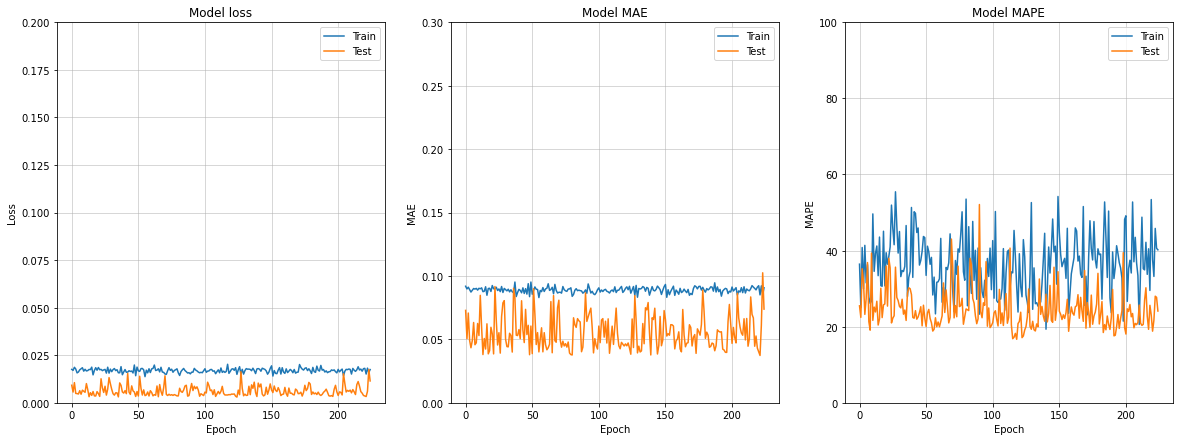

In [37]:
plot_history(history)

In [38]:
model.evaluate(X_test_pad, y_test)

16/16 [==============================] - 0s 12ms/step - loss: 16.9230 - mean_absolute_percentage_error: 49.0258 - mean_absolute_error: 3.6217


[16.922956466674805, 49.02581024169922, 3.621659994125366]

In [28]:
a = np.zeros((1,7))
a[0][1] = 3.3477
a

array([[0.    , 3.3477, 0.    , 0.    , 0.    , 0.    , 0.    ]])

In [29]:
scaler.inverse_transform(a)

array([[3.30389124e+01, 8.04614792e+01, 2.30749017e+08, 3.43124000e+01,
        3.14138922e+01, 3.29837653e+01, 5.47526617e-04]])